# Data Visualization Tutorial with Mahjong Matchmaking Toolkit (MMT)
##### The following release versions are used:
* [Python 3.4.4](https://www.python.org/download/releases/3.4.4/)
* [NumPy 1.11.0](http://www.scipy.org/scipylib/download.html) for an efficient multidimensional container of generic data 
* [pandas 0.18.1](https://pypi.python.org/pypi/pandas) for data manipulation with integrated indexing

In this tutorial, we take on the role of a mahjong group coordinator who wants to visualize play group statistics. Using MMT in conjunction with the [`matplotlib 1.5.1`](http://matplotlib.org/) and [`seaborn 0.7.0`](http://stanford.edu/~mwaskom/software/seaborn/) data visualization libraries, we can take a look at how our players are doing.

The mahjong group has 98 people in it, but only 27 players showed up today. Ignoring all other group members, how well do the players from today typically do against each other? Let's find out by:
1. [Importing historical game data](#1.-Import-Historical-Game-Data), 
2. [Plotting a heatmap](#2.-Plot-a-Heatmap) of player matchup scores, and
3. [Creating a bar chart](#3.-Plot-a-Bar-Chart) with each player's average rank.

### 1. Import Historical Game Data
Since our goal is to assemble some basic information about how players match up against each other, let's first import our historical data.

The mahjong group stores its data in a **`.csv`** file, so we can start by importing pandas to read the file. Since pandas handles everything from SQL queries to Excel spreadsheets, don't feel limited to **`.csv`** files!*

To simplify extracting matchup data, we import MMT.

Lastly, we import `matplotlib` and `seaborn` to plot the heatmap and bar chart that we want. Calling `%matplotlib inline` allows us to view our plots directly in this notebook:

In [1]:
import pandas as pd
import mahjong as mmt
import seaborn as sns
import matplotlib.pyplot as plt

# Call inline to view our plots directly
%matplotlib inline

# pd.read_csv() imports our data and assigns it directly to a pandas DataFrame object
input_data = pd.read_csv('MahjongScores.csv')

#### Check input data

To preview our data, we call the pandas [`DataFrame.head()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html#pandas.DataFrame.head) method. With no arguments, it returns the first 5 rows:

In [2]:
input_data.head()

,ScoreId,GameId,PlayerId,Rank,RawScore,Score,Unnamed: 6
0,1,1,23,1,0,38,NaN
1,2,1,52,2,0,13,NaN
2,3,1,6,3,0,-9,NaN
3,4,1,98,4,0,-42,NaN
4,5,2,6,1,0,30,NaN


It looks like `input_data` contains all required column headers (`GameId`, `PlayerId`, `Rank`, and `Score`), so no additional formatting is necessary.

#### Generate a matchup table
In our heatmap, we want to show each individual's average score when sitting at the table of any given opponent. To get there, we'll first generate a matchup table for all of today's players, then convert it into a figure.

Let's begin by giving MMT a list of `PlayerId`s for the 27 people who played today.

In [3]:
todays_players = [40,6,23,26,97,98,1,10,55,16,
                  56,90,96,12,13,41,52,88,66,94,
                  89,86,87,77,79,72,76]
print(len(todays_players))

27


Next, we call `create_pairings_df()` with only today's players and store it as `pairings_df`.

This gives us an empty `DataFrame` with `PlayerId` values as labels sorted along each axis:

In [4]:
pairings_df = mmt.create_pairings_df(todays_players)
pairings_df.head()

,1,6,10,12,13,16,23,26,40,41,...,79,86,87,88,89,90,94,96,97,98
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calling `generate_score_mmr()` then populates our newly made pairings table with the average scores using `input_data`:

In [5]:
# Populate pairings_df with average scores and assign to score_matchups
score_matchups = mmt.generate_score_mmr(pairings_df, input_data)
score_matchups.head()

,1,6,10,12,13,16,23,26,40,41,...,79,86,87,88,89,90,94,96,97,98
1,-4.909091,-0.455882,2.363636,0.406250,0.000000,0.000000,0.000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-0.030675
6,1.454545,6.470588,0.000000,0.812500,1.178571,-5.666667,-0.120,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,2.583333,4.277778,0.0,0.0,0.0,0.079755
10,-1.000000,0.000000,-0.090909,-0.171875,0.000000,0.000000,-0.328,0.0,0.0,0.0,...,0.0,1.6,-12.333333,0.0,0.000000,0.000000,0.0,0.0,0.0,-0.165644
12,-2.636364,-1.514706,-2.636364,-9.625000,-2.678571,0.000000,-2.992,0.0,0.0,0.0,...,0.0,6.3,0.000000,8.0,0.583333,0.000000,0.0,0.0,0.0,-1.668712
13,0.000000,-0.705882,0.000000,1.187500,6.821429,2.333333,-0.120,0.0,0.0,0.0,...,0.0,3.9,0.000000,0.0,0.000000,-2.666667,0.0,0.0,0.0,0.337423


### 2. Plot a Heatmap

At this point, we're ready to plot our heatmap. Because scores can be either positive or negative, a [diverging color palette](http://stanford.edu/~mwaskom/software/seaborn/tutorial/color_palettes.html?highlight=diverging%20palette) makes the most sense. We'll apply the blue-white-red colormap included in `seaborn` to help with accessibility.

Using `score_matchups` as the source data, call [`sns.heatmap()`](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.heatmap.html) to generate the plot. The additional arguments below resize the figure and assign a colormap:

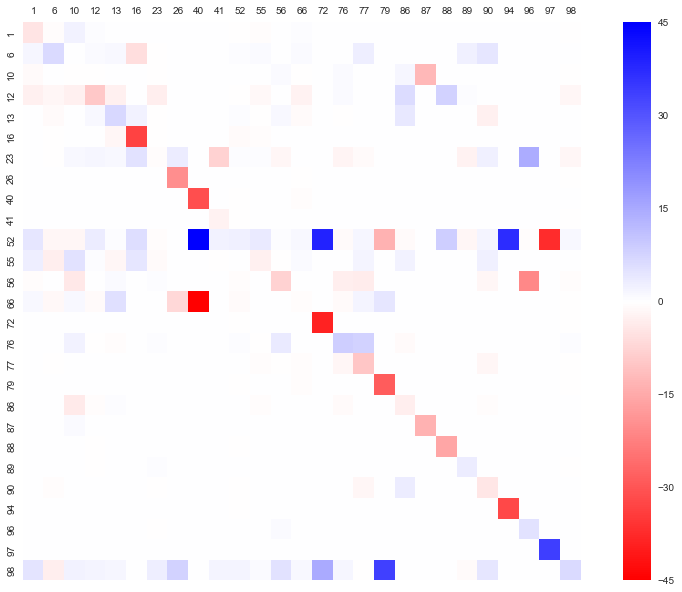

In [6]:
# Plot a heatmap of matchups, where diagonal is player personal average
plt.figure(figsize=(15,10))
ax = sns.heatmap(score_matchups, cmap='bwr_r', square=True, vmin=-45, vmax=45)
ax.xaxis.tick_top()

To read this, we look at the y-axis for a player and the x-axis for their opponent. For example, we see here that player 52 tends to do well against players 40, 72, and 94, but poorly against players 79 and 97.

With this heatmap, we can also gauge each player's personal average by the color of their position on the diagonal. A quick glance shows that player 97 has the highest average score of everybody in today's player pool.

#### Obtain aggregate data

Next, let's work on making a bar chart of each player's average table ranking. For this figure, we want average rank on the y-axis, and `PlayerId` on the x-axis. To minimize the amount of manual data transformation we need to do, we call `playerstats()` for the aggregate data:

In [7]:
aggregate_data = mmt.playerstats(input_data, todays_players)
aggregate_data

,1,6,10,12,13,16,23,26,40,41,...,79,86,87,88,89,90,94,96,97,98
Total games played,11,68,11,64,28,6,125,4,1,5,...,2,10,3,2,12,18,1,2,1,163
4p games played,7,49,9,37,19,3,78,3,0,4,...,1,9,3,2,7,12,1,1,1,107
5p games played,4,19,2,27,9,3,47,1,1,1,...,1,1,0,0,5,6,0,1,0,56
Mean score,-4.91,6.47,-0.09,-9.62,6.82,-33.17,-0.69,-20,-31,-2.2,...,-28.5,-3.1,-13.67,-15.5,3.5,-4.22,-32,5,34,6.59
Stdev score,24.6,27.07,28.31,27.48,26.66,16.04,24.03,21.23,NaN,25.87,...,17.68,27.85,20.6,3.54,28.57,26.7,NaN,36.77,NaN,26.74
Mean rank,2.82,2.41,2.64,3.17,2.36,4.17,2.7,3.5,4,2.6,...,4,2.6,3,3,2.67,2.83,4,2.5,1,2.39
Stdev rank,1.25,1.26,1.29,1.25,1.25,0.75,1.13,0.58,NaN,1.52,...,0,1.17,1,0,1.37,1.29,NaN,2.12,NaN,1.23
Mean 4p rank,2.71,2.27,2.67,3.03,2.05,3.67,2.62,3.67,NaN,2,...,4,2.78,3,3,2,2.33,4,1,1,2.13
Stdev 4p rank,1.25,1.15,1.22,1.01,1.03,0.58,1.01,0.58,NaN,0.82,...,NaN,1.09,1,0,1.15,1.15,NaN,NaN,NaN,1.04
Mean 5p rank,3,2.79,2.5,3.37,3,4.67,2.83,3,4,5,...,4,1,NaN,NaN,3.6,3.83,NaN,4,NaN,2.89


While we only need the "Mean rank" and "Stdev rank" rows right now, you'll notice that `playerstats()` returns other useful information as well.

### 3. Plot a Bar Chart

For visual clarity, let's reduce the table to the most relevant information and sort it by `'Mean rank'`. Unfortunately, the pandas `DataFrame` object doesn't have a one-step method for sorting based on row values. As a workaround, we first transpose the DataFrame before sorting:

In [8]:
subset = aggregate_data.loc[['Mean rank','Stdev rank']].transpose()
subset.sort_values(by='Mean rank', inplace=True)
subset.head()

,Mean rank,Stdev rank
97,1,NaN
76,2.29,1.09
13,2.36,1.25
98,2.39,1.23
6,2.41,1.26


Finally, we use [`matplotlib.pyplot.plot()`](http://matplotlib.org/api/pyplot_api.html) to draw each player's average rank in a bar chart, and use the error bars argument to draw our standard deviations:

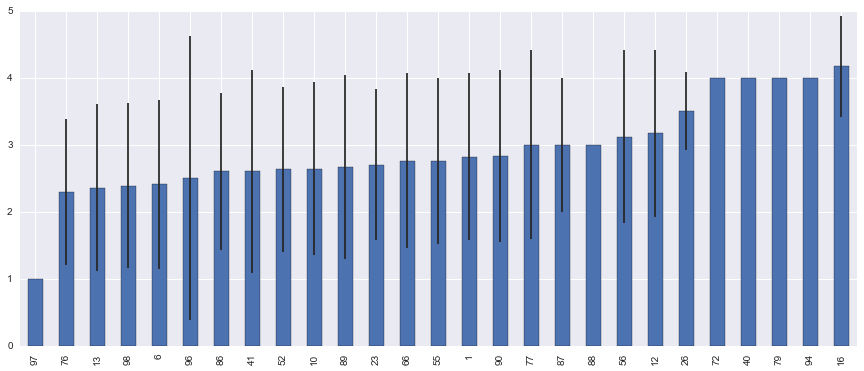

In [9]:
subset['Mean rank'].plot(yerr=subset['Stdev rank'], kind='bar', figsize=(15,6))

And in a few short steps, we've made two figures to quickly compare today's players with each other!